In [7]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df = pd.read_excel(url)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Minute'] = df['InvoiceDate'].dt.minute
df['Invoice_str'] = df['Invoice'].astype(str)
df['CustomerID_str'] = df['Customer ID'].astype(str)
df['StockCode_str'] = df['StockCode'].astype(str)
df.dropna(how= 'any')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Invoice_str,CustomerID_str,StockCode_str
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,85048
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323P
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323W
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,22041
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,21232


In [ ]:
df['Quarter'] = df['InvoiceDate'].dt.quarter
df['TotalAmount'] = df['Quantity'] * df['Price']

In [ ]:
# Feature Engineering Puchase Variables For Each Unique Customer

MonthlyPurchaseQuantity = df.groupby(['Customer ID', 'Month'])['Quantity'].sum().reset_index()
df = pd.merge(df, MonthlyPurchaseQuantity, on= ['Customer ID', 'Month'], suffixes= ['', '_perMonth'])

MonthlyPurchaseAmount = df.groupby(['Customer ID', 'Month'])['TotalAmount'].sum().reset_index()
df = pd.merge(df, MonthlyPurchaseAmount, on= ['Customer ID', 'Month'], suffixes= ['', '_perMonth'])

YearlyPurchaseQuantity = df.groupby(['Customer ID', 'Year'])['Quantity'].sum().reset_index()
df  = pd.merge(df, YearlyPurchaseQuantity, on= ['Customer ID', 'Year'], suffixes= ['', '_perYear'])

YearlyPurchaseAmount = df.groupby(['Customer ID', 'Year'])['TotalAmount'].sum().reset_index()
df = pd.merge(df, YearlyPurchaseAmount, on= ['Customer ID', 'Year'], suffixes= ['', '_perYear'])

In [ ]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Month', 'Year', 'Day', 'Hour',
       'Minute'],
      dtype='object')

What item is the best seller in every month based on the dataset?

In [ ]:
monthly_sales = df.groupby(['Month', 'StockCode'])['Quantity'].sum().reset_index()
best_sellers = monthly_sales.loc[monthly_sales.groupby('Month')['Quantity'].idxmax()]
best_sellers = best_sellers.merge(df[['StockCode', 'Description']], on='StockCode', how='left')
for month in best_sellers['Month'].unique():
    item_info = best_sellers[best_sellers['Month'] == month].iloc[0]
    print(f"In month {month}, the best-selling item is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with a quantity of {item_info['Quantity']}.")



In month 1, the best-selling item is 'JAZZ HEARTS MEMO PAD' (StockCode: 20993) with a quantity of 9500.
In month 2, the best-selling item is 'BLACK AND WHITE PAISLEY FLOWER MUG' (StockCode: 37410) with a quantity of 19249.
In month 3, the best-selling item is 'SET/6 WOODLAND PAPER PLATES' (StockCode: 21091) with a quantity of 13107.
In month 4, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 5365.
In month 5, the best-selling item is 'FLAG OF ST GEORGE CAR FLAG' (StockCode: 84016) with a quantity of 11097.
In month 6, the best-selling item is 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' (StockCode: 84077) with a quantity of 5515.
In month 7, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 4181.
In month 8, the best-selling item is 'SET/6 FRUIT SALAD PAPER CUPS' (StockCode: 21088) with a quantity of 7131.
In month 9, the best-selling item is 'BROCADE RING PURSE ' (StockCode: 17003) with a quantity

What item is the best seller in every quarter based on the dataset?

---



In [ ]:
df['Quarter'] = df['InvoiceDate'].dt.quarter
quarterly_sales = df.groupby(['Quarter', 'StockCode'])['Quantity'].sum().reset_index()
best_sellers = quarterly_sales.loc[quarterly_sales.groupby('Quarter')['Quantity'].idxmax()]
best_sellers = best_sellers.merge(df[['StockCode', 'Description']], on='StockCode', how='left')
best_sellers = best_sellers[['Quarter', 'StockCode', 'Description', 'Quantity']]
for quarter in best_sellers['Quarter'].unique():
    item_info = best_sellers[best_sellers['Quarter'] == quarter].iloc[0]
    print(f"In quarter {quarter}, the best-selling item is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with a quantity of {item_info['Quantity']}.")

In quarter 1, the best-selling item is 'BLACK AND WHITE PAISLEY FLOWER MUG' (StockCode: 37410) with a quantity of 24988.
In quarter 2, the best-selling item is 'FLAG OF ST GEORGE CAR FLAG' (StockCode: 84016) with a quantity of 17281.
In quarter 3, the best-selling item is 'BROCADE RING PURSE ' (StockCode: 17003) with a quantity of 17030.
In quarter 4, the best-selling item is 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' (StockCode: 84077) with a quantity of 21478.


Which region is this business most successful in? Calculate the total sales for each country and find the biggest sales.

In [ ]:
country_sales = df.groupby('Country')['Quantity'].sum().reset_index()
most_successful_region = country_sales.loc[country_sales['Quantity'].idxmax()]
print("The most successful region for the business is:", most_successful_region['Country'])

The most successful region for the business is: United Kingdom


Which region is this business least successful in? Calculate the total sales for each country and find the lowest sales.*italicized text*

In [ ]:
most_successful_region = country_sales.loc[country_sales['Quantity'].idxmin()]
print("The least successful region for the business is:", most_successful_region['Country'])

The least successful region for the business is: Nigeria


What is the largest transaction on an invoice based on the dataset?


In [ ]:
df['TotalAmount'] = df['Quantity'] * df['Price']
invoice_totals = df.groupby('Invoice')['TotalAmount'].sum().reset_index()
largest_transaction = invoice_totals.loc[invoice_totals['TotalAmount'].idxmax()]
print("The largest transaction on an invoice is: Total Amount =", largest_transaction['TotalAmount'],
      "Invoice Number =", largest_transaction['Invoice'])

The largest transaction on an invoice is: Total Amount = 49844.990000000005 Invoice Number = 533027


What is the mean revenue of this business per month?


In [ ]:
mean_revenue_per_month = df.groupby('Month')['TotalAmount'].sum().mean()
print("The mean revenue of the business per month is:", mean_revenue_per_month)

The mean revenue of the business per month is: 794957.0528333333


Calculate total revenue for this business for each month based on the dataset

In [ ]:
monthly_revenue = df.groupby('Month')['TotalAmount'].sum()
for month, revenue in monthly_revenue.items():
    print(f"Month {month}: Total Revenue = {revenue}")


Month 1: Total Revenue = 624032.892
Month 2: Total Revenue = 533091.426
Month 3: Total Revenue = 765848.761
Month 4: Total Revenue = 590580.432
Month 5: Total Revenue = 615322.83
Month 6: Total Revenue = 679786.61
Month 7: Total Revenue = 575236.36
Month 8: Total Revenue = 656776.34
Month 9: Total Revenue = 853650.431
Month 10: Total Revenue = 1045168.35
Month 11: Total Revenue = 1422654.642
Month 12: Total Revenue = 1177335.56


Calculate the average number of transactions per month for this business.

---




In [ ]:
monthly_transactions = df.groupby('Month')['Invoice'].nunique()
average_transactions_per_month = monthly_transactions.mean()
print("The average number of transactions per month for this business is:", average_transactions_per_month)


The average number of transactions per month for this business is: 2401.3333333333335


Calculate the average total sales on the invoice for this business.

In [ ]:
invoice_total_sales = df.groupby('Invoice')['TotalAmount'].sum()
average_total_sales_per_invoice = invoice_total_sales.mean()
print("The average total sales on each invoice for this business is:", average_total_sales_per_invoice)




The average total sales on each invoice for this business is: 331.0481896862854


Predict the average revenue per month by multiplying the average number of transactions (invoices) with the average total sales per invoice.

In [ ]:
print(average_transactions_per_month * average_total_sales_per_invoice)

794957.0528333334


Build a linear regression model that best predicts the total sales per month for this business by using appropriate variables. Compare it to the previous prediction. Calculate the MSE and r2 Score.

In [ ]:
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['InvoiceDate'].dt.month
X = monthly_sales[['Month']]
y = monthly_sales['TotalAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

LMCoef = model.coef_
LMInter = model.intercept_

print("Linear Regression Model Parameters - ", "Coefficients: ", LMCoef, " Model Intercept: ", LMInter, "\n")

print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Linear Regression Model Parameters -  Coefficients:  [2513.43628315]  Model Intercept:  631755.3146577062 

Mean Squared Error:  213762645808.79013
R^2 Score:  -1.6924138549607326


<Axes: xlabel='Month', ylabel='TotalAmount'>

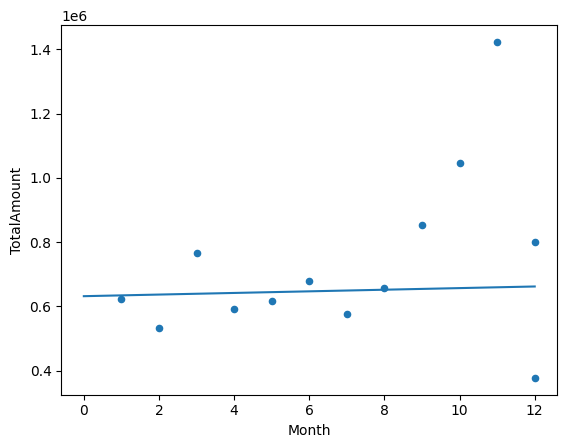

In [ ]:
# Graph of Linear Regression Model

X_new = pd.DataFrame()
X_new["Month"] = np.linspace(0, 12, num=60)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["Month"]
)

# Plot the predictions.
monthly_sales.plot.scatter(x="Month", y="TotalAmount")
y_new_.plot.line()

########################################
K-Means questions tbd

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='Price', ylabel='Quantity'>

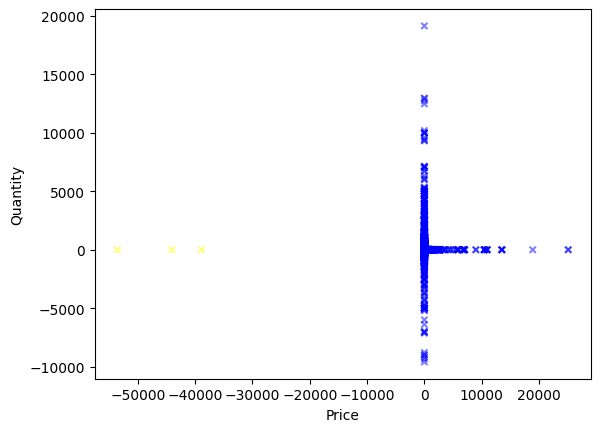

In [ ]:
# K - Means Cluster
X_train = df[["Price", "Quantity"]]
X_train = pd.get_dummies(X_train)
X_train.dropna(inplace=True)


#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=2)
model.fit(X_train)

clusters = pd.Series(model.labels_).map({
    0: "blue",
    1: "yellow",
})

X_train.plot.scatter(x="Price", y="Quantity",
                     c=clusters, marker="x", alpha=.5)

##########

Build a KNN regression model that best predicts the total sales per month for this business by using appropriate variables. Use hyperparameter tuning to determine the best value of K to use in the model. Compare it to the previous predictions and results from the linear regression model


9    3.324752e+10
7    3.460870e+10
8    3.524540e+10
6    3.804411e+10
5    3.939829e+10
4    4.437263e+10
3    4.793112e+10
2    6.212064e+10
1    1.033543e+11
dtype: float64

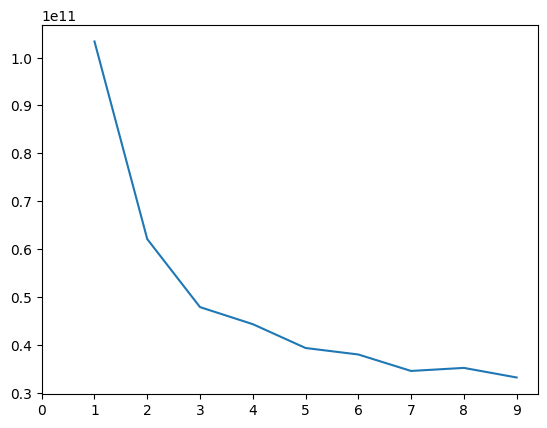

In [ ]:
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['InvoiceDate'].dt.month
X = monthly_sales[['Month']]
y = monthly_sales['TotalAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for KNN Model

def get_cv_error(k):
  knn_model = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k)
  )

  cv_errs = -cross_val_score(knn_model, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  return cv_errs.mean()

ks = pd.Series(range(1, 10))
ks.index = range(1, 10)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line(xticks=range(0,10))
test_errs.sort_values()

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors = 9)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", knn_mse)
print("R^2 Score: ", knn_r2)

Mean Squared Error:  221201646981.31482
R^2 Score:  -1.7861106266684068


In [ ]:
monthly_sales.head()

,InvoiceDate,TotalAmount,Month
0,2009-12,799847.110,12
1,2010-01,624032.892,1
2,2010-02,533091.426,2
3,2010-03,765848.761,3
4,2010-04,590580.432,4


<Axes: xlabel='Month', ylabel='TotalAmount'>

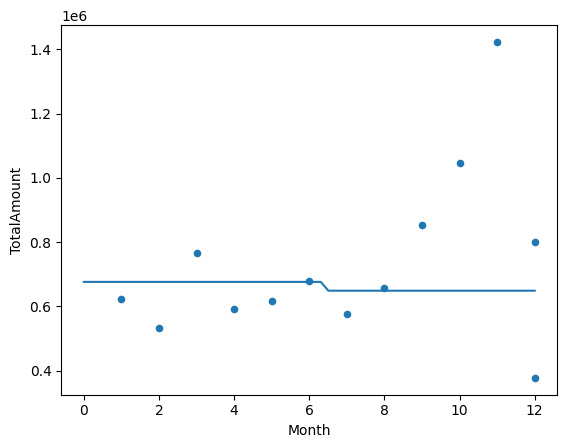

In [ ]:
# Graph of KNN Model

X_new = pd.DataFrame()
X_new["Month"] = np.linspace(0, 12, num=60)

# Make predictions at those feature values.
y_new_ = pd.Series(
    knn_model.predict(X_new),
    index=X_new["Month"]
)

# Plot the predictions.
monthly_sales.plot.scatter(x="Month", y="TotalAmount")
y_new_.plot.line()

<Axes: xlabel='Month', ylabel='TotalAmount'>

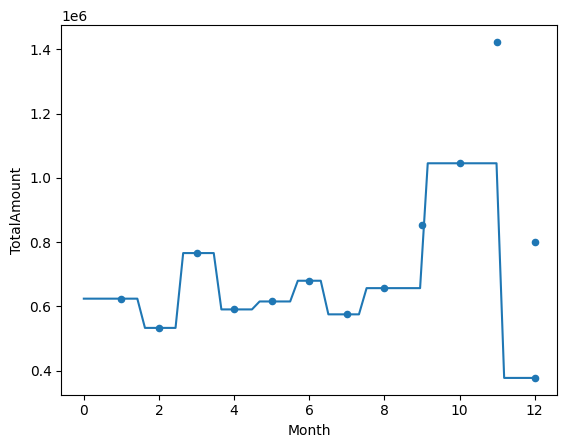

In [ ]:
# KNN Model with K = 1
knn_model = KNeighborsRegressor(n_neighbors = 1)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)

X_new = pd.DataFrame()
X_new["Month"] = np.linspace(0, 12, num=60)

# Make predictions at those feature values.
y_new_ = pd.Series(
    knn_model.predict(X_new),
    index=X_new["Month"]
)

# Plot the predictions.
monthly_sales.plot.scatter(x="Month", y="TotalAmount")
y_new_.plot.line()

What is the best selling product for each country?

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Invoice_str,CustomerID_str,StockCode_str,Quarter,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,85048,4,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323P,4,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323W,4,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,22041,4,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,21232,4,30.0


In [ ]:
country_sales = df.groupby(['Country', 'StockCode'])['Quantity'].sum().reset_index()
country_best_seller = country_sales.loc[country_sales.groupby('Country')['Quantity'].idxmax()]
country_best_seller = country_best_seller.merge(df[['StockCode', 'Description']], on='StockCode', how='left')
country_best_seller.head()

,Country,StockCode,Quantity,Description
0,Australia,22951,504,72 CAKE CASES DOLLY GIRL DESIGN
1,Australia,22951,504,72 CAKE CASES DOLLY GIRL DESIGN
2,Australia,22951,504,72 CAKE CASES DOLLY GIRL DESIGN
3,Australia,22951,504,60 CAKE CASES DOLLY GIRL DESIGN
4,Australia,22951,504,60 CAKE CASES DOLLY GIRL DESIGN


In [ ]:
for country in country_best_seller['Country'].unique():
  item_info = country_best_seller[country_best_seller['Country'] == country].iloc[0]
  print(f"For Country {country}, the best-selling item is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with a quantity of {item_info['Quantity']}.")

For Country Australia, the best-selling item is '72 CAKE CASES DOLLY GIRL DESIGN' (StockCode: 22951) with a quantity of 504.
For Country Austria, the best-selling item is 'MINI HIGHLIGHTER PENS' (StockCode: 16033) with a quantity of 120.
For Country Bahrain, the best-selling item is 'WHITE TALL PORCELAIN T-LIGHT HOLDER' (StockCode: 18097C) with a quantity of 102.
For Country Belgium, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 336.
For Country Bermuda, the best-selling item is 'GIRLS ALPHABET IRON ON PATCHES ' (StockCode: 84568) with a quantity of 1152.
For Country Brazil, the best-selling item is 'DRAGONS BLOOD INCENSE' (StockCode: 17084P) with a quantity of 25.
For Country Canada, the best-selling item is 'JAZZ HEARTS ADDRESS BOOK' (StockCode: 20996) with a quantity of 24.
For Country Channel Islands, the best-selling item is 'JUMBO BAG PINK WITH WHITE SPOTS' (StockCode: 22386) with a quantity of 330.
For Country Cyprus, the best-

What is the product that generates the most revenue for each country?

In [ ]:
country_product_revenue = df.groupby(['Country', 'Description'])['TotalAmount'].sum()
best_country_product = country_product_revenue.groupby('Country').idxmax()
country_winning_product = country_product_revenue.loc[best_country_product]
country_winning_product

Country               Description                        
Australia             REGENCY CAKESTAND 3 TIER                  927.00
Austria               POSTAGE                                  1520.00
Bahrain               WHITE TALL PORCELAIN T-LIGHT HOLDER       202.50
Belgium               POSTAGE                                  2398.00
Bermuda               BOYS ALPHABET IRON ON PATCHES             241.92
Brazil                FRENCH PAISLEY CUSHION COVER               17.70
Canada                RETROSPOT SMALL TUBE MATCHES               33.00
Channel Islands       AFGHAN SLIPPER SOCK PAIR                  885.00
Cyprus                REGENCY CAKESTAND 3 TIER                  567.15
Denmark               SMALL FAIRY CAKE FRIDGE MAGNETS          2836.80
EIRE                  REGENCY CAKESTAND 3 TIER                 7524.90
Finland               PINK 3 PIECE MINI DOTS CUTLERY SET        555.66
France                POSTAGE                                  9442.00
Germany            

In [ ]:
country_product_revenue = df.groupby(['Country', 'StockCode'])['TotalAmount'].sum().reset_index()
best_country_product = country_product_revenue.loc[country_product_revenue.groupby('Country')['TotalAmount'].idxmax()]
best_country_product = best_country_product.merge(df[['StockCode', 'Description']], on='StockCode', how='left')

for country in best_country_product['Country'].unique():
  item_info = best_country_product[best_country_product['Country'] == country].iloc[0]
  print(f"For Country {country}, the product that generates the most revenue is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with total sales of ${item_info['TotalAmount']}.")

For Country Australia, the product that generates the most revenue is 'REGENCY CAKESTAND 3 TIER' (StockCode: 22423) with total sales of $927.0.
For Country Austria, the product that generates the most revenue is 'POSTAGE' (StockCode: POST) with total sales of $1520.0.
For Country Bahrain, the product that generates the most revenue is 'WHITE TALL PORCELAIN T-LIGHT HOLDER' (StockCode: 18097C) with total sales of $202.5.
For Country Belgium, the product that generates the most revenue is 'POSTAGE' (StockCode: POST) with total sales of $2398.0.
For Country Bermuda, the product that generates the most revenue is 'GIRLS ALPHABET IRON ON PATCHES ' (StockCode: 84568) with total sales of $241.92.
For Country Brazil, the product that generates the most revenue is 'FRENCH PAISLEY CUSHION COVER ' (StockCode: 20839) with total sales of $17.700000000000003.
For Country Canada, the product that generates the most revenue is 'RETRO SPOT SMALL TUBE MATCHES' (StockCode: 21584) with total sales of $33.0

############################################ Clustering Model ####################
Can customers be segmented based on purchasing behavior (frequent buyer, seasonal buyer, occasional buyer, etc.) through the use of clustering?
This is done through feature engineering the variables purchase quantity per month, purchase amount ($) per month, purchase amount ($) per year, purchase quantity per year, and using these variables as predictors. Then clusters can be visualized with scatterplots of these variables


In [6]:
# Define a repeat customer
df['RepeatCustomer'] = (df.groupby('Customer ID')['Invoice'].transform('nunique') > 1).astype(int)

# Feature Engineering
df['Return'] = (df['Quantity'] < 0).map({True: 'Yes', False: 'No'})

# Define predictors and target
x_predictors = df[['StockCode', 'Customer ID', 'Country', 'Price', 'Month', 'Day', 'Hour', 'Minute']]
y_result = df['Return']

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_predictors, y_result, train_size=0.8, shuffle=False)

# Preprocessing
ct = make_column_transformer(
    (StandardScaler(), ['Price']),
    (OneHotEncoder(handle_unknown='ignore'), ['StockCode', 'Customer ID', 'Country']),
    remainder='passthrough'
)

# Classification model
class_model_return = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=5)
)

# Train the model
class_model_return.fit(x_train, y_train)

# Scoring for the classification model
# Cross-validation scores for training set
train_cv_scores = cross_val_score(class_model_return, x_train, y_train, cv=4, scoring="accuracy")
train_accuracy = train_cv_scores.mean()

# Convert 'Yes'/'No' labels to boolean values for F1 score calculation
train_returned = (y_train == 'Yes')

# Calculate F1 score using cross-validation for training set
train_f1 = cross_val_score(class_model_return, x_train, train_returned, cv=10, scoring="f1").mean()

# Display results
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)


<ipython-input-6-3d7f03d249c5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_predictors['StockCode'] = x_predictors['StockCode'].astype(str)
<ipython-input-6-3d7f03d249c5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_predictors['Customer ID'] = x_predictors['Customer ID'].astype(str)
<ipython-input-6-3d7f03d249c5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

KeyboardInterrupt: 